In [13]:
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
from kerashypetune import KerasGridSearch

from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot

In [14]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

In [15]:
cd

/Users/pranavtushar


In [16]:
# load all train
X_train, y_train = load_dataset('train', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


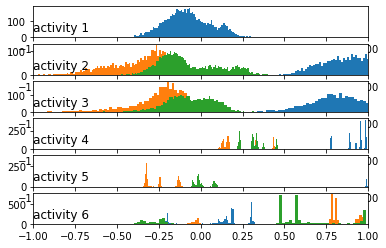

In [17]:
sub_map = load_file('/Users/pranavtushar/Documents/time-series/HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map)
sub_map1 = load_file('/Users/pranavtushar/Documents/time-series/HARDataset/test/subject_test.txt')
test_subjects = unique(sub_map1)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(X_train, y_train, sub_map, sub_id)
sub_id1 = test_subjects[0]
subX1, suby1 = data_for_subject(X_test, y_test, sub_map, sub_id1)
# plot data for subject
plot_activity_histograms(subX, suby)
# plot_activity_histograms(subX1, suby1)

In [18]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p #if i = 0
        sin_trans = K.sin(K.dot(x, self.W) + self.P) # Frequecy and phase shift of sine function, learnable parameters. if 1 <= i <= k
        
        return K.concatenate([sin_trans, original], -1)

In [19]:
class Time2Vec:

    def __init__(self, 
                param={
                    'unit': 32,
                    't2v_dim': 64,
                    'lr': 1e-2, 
                    'act': 'relu', 
                    'epochs': 5,
                    'batch_size': 1024
                }, dim=20):
        self.param = param
        self.dim = dim

    def set_LSTM(self):  
        inp = layers.Input(shape=(self.dim,9))
        x = T2V(self.param['t2v_dim'])(inp)
        x = LSTM(self.param['unit'], activation=self.param['act'])(x)
        x = Dense(1)(x)
        m = Model(inp, x)
        m.compile(loss='mse', optimizer='adam')
        m.summary()
        self.model = m
    
    def train(self, X_train, y_train):

        self.history = self.model.fit(X_train, y_train, epochs=20, validation_split=0.2, shuffle=False)
    
    def plot_training(self):

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def evaluate(self, X_test, y_test):

        self.model.evaluate(X_test, y_test)

    def plot_predictions(self, y_test, y_hat, item="HAR Activity"):

        plt.plot(y_test, label=f"Actual {item}", color='green')
        plt.plot(y_hat, label=f"Predicted {item}", color='red')
        
        plt.title(f'{item} prediction')
        plt.xlabel('Time [days]')
        plt.ylabel(f'{item}')
        plt.legend(loc='best')
        plt.show()
    

In [20]:
model_instance = Time2Vec(dim=128)
model_instance.set_LSTM()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
t2v_1 (T2V)                  (None, 128, 73)           9024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                13568     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,625
Trainable params: 22,625
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_instance.train(X_train, y_train)
y_hat = model_instance.model.predict(X_test)

Epoch 1/20
184/184 [==============================] - 6s 30ms/step - loss: 7.8644 - val_loss: 2.2224
Epoch 2/20
184/184 [==============================] - 5s 30ms/step - loss: 1.7387 - val_loss: 2.1691
Epoch 3/20
184/184 [==============================] - 5s 29ms/step - loss: 1.6898 - val_loss: 2.1324
Epoch 4/20
184/184 [==============================] - 5s 29ms/step - loss: 39.3455 - val_loss: 3.8716
Epoch 5/20
184/184 [==============================] - 6s 31ms/step - loss: 3.1738 - val_loss: 2.0948
Epoch 6/20
184/184 [==============================] - 5s 29ms/step - loss: 1.9927 - val_loss: 2.0370
Epoch 7/20
184/184 [==============================] - 5s 29ms/step - loss: 1.9237 - val_loss: 1.9865
Epoch 8/20
184/184 [==============================] - 5s 29ms/step - loss: 1.8612 - val_loss: 1.9440
Epoch 9/20
184/184 [==============================] - 5s 29ms/step - loss: 1.8061 - val_loss: 1.9090
Epoch 10/20
184/184 [==============================] - 5s 29ms/step - loss: 1.7585 - val_l

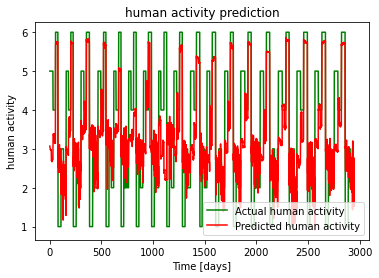

In [22]:
model_instance.plot_predictions(y_test, y_hat, item= "human activity")

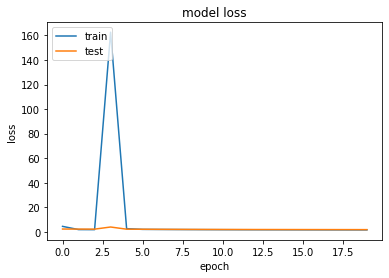

In [23]:
 model_instance.plot_training()

In [24]:
model_instance.evaluate(X_test, y_test)

93/93 [==============================] - 1s 8ms/step - loss: 1.6697
